In [12]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import spearmanr

In [ ]:
## need biopython to run: https://anaconda.org/anaconda/biopython
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq

In [13]:
## need OligoArrayAux to run: http://www.unafold.org/Dinamelt/software/OligoArrayAux.php
## install: https://libraries.io/pypi/oligo-melting
import oligo_melting as OligoMelt

In [14]:
sns.set()

## Import data and graph

,Unnamed: 0,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,2708.0,0.410978,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,-41
1,1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,1558.0,0.236425,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,-39
2,2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,360.0,0.054586,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-41
3,3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,2602.0,0.394889,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,-42
4,4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,1844.0,0.279835,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,-42


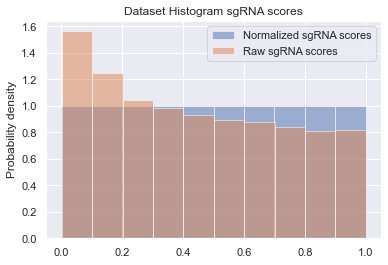

In [34]:
df = pd.read_csv("Doench_Fusi_V2_Featurized.csv")
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("Dataset Histogram sgRNA scores")
plt.legend()
df.head()

In [35]:
df.shape

(6588, 2496)

### Metrics

In [60]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import r2_score

def get_metrics(y_true, y_pred):
    #accuracy = accuracy_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spr = spearmanr(y_true, y_pred)
    return {
        'mse' : mse,
        'r2' : r2,
        'spearman': spearmanr(y_true, y_pred)[0]
    }   


"'accuracy': accuracy,\n        'error': 1 - accuracy,\n        'precision': precision_score(y_true, y_pred),\n        'recall': recall_score(y_true, y_pred),\n        'f1_score': f1_score(y_true, y_pred),\n        'spearman': spearmanr(y_true, y_pred)"

### Models

In [37]:
features = df.columns.values
y_feat = "sgRNA Normalized"
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
x_feat = features
x_feat = np.delete(x_feat, 0)
x_feat

array(['AG1', 'AC1', 'AT1', ..., 'TTC', 'TTT', 'Delta G'], dtype=object)

In [133]:
y = df.loc[:,y_feat].values
x = df[x_feat].values
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1
)

## 10-fold cross validation

In [39]:
def cross_validate_regression(model, df, x_feat_list, y_feat, n_splits=10):
    # computes the spearman correlation coefficient for each cross validated data set
    # takes in a model (estimator object), pandas dataframe, x features and the y-feature to predict, as well
    # as the number of splits (default is 10)
    #
    # returns a list of spearman correlation coefficients with length equal to the input n_splits
    
    # extract data into matrix
    x = df.loc[:, x_feat_list].values
    y_true = df.loc[:, y_feat].values
    
    kfold = KFold(n_splits=n_splits)
    
    # initialize an empty array same size as y_true
    y_pred = np.empty_like(y_true)
    
    # correlation list
    scc_list = np.array([])
    
    for train_idx, test_idx in kfold.split(x, y_true):
        # get training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]

        # train on training data
        model.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_pred[test_idx] = model.predict(x_test)
        
        scc_list = np.append(scc_list, spearmanr(y_pred[test_idx], y_true[test_idx]).correlation)
    
    return scc_list

### Gradient-Boosted Regression Tree

In [41]:
params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

params2 = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params2)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0765


In [61]:
ns = [1, 5, 10, 100, 1000]

for n in ns:
    params = {
    "n_estimators": n,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    }

    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    reg_ypred = reg.predict(X_test)

    print("For n_estimators = {}".format(n))
    print(get_metrics(y_test, reg_ypred))

For n_estimators = 1
{'mse': 0.08918636802443654, 'r2': 0.0026451994071469143, 'spearman': 0.39211559511194666}
For n_estimators = 5
{'mse': 0.0882797271636152, 'r2': 0.012783997913955236, 'spearman': 0.39234539171438076}
For n_estimators = 10
{'mse': 0.08726001787434283, 'r2': 0.02418721992414241, 'spearman': 0.379323236873127}
For n_estimators = 100
{'mse': 0.07652950188341422, 'r2': 0.14418461272590677, 'spearman': 0.4860136920685022}
For n_estimators = 1000
{'mse': 0.06073640762812914, 'r2': 0.32079588999429176, 'spearman': 0.5827401068419379}


In [21]:
# NOTE: this will take a while (~10 minutes) to run
gbrt_cvssc = cross_validate_regression(reg, df, x_feat, y_feat, 10)
gbrt_cvssc

array([0.92234138, 0.89011857, 0.91850165, 0.84646242, 0.85715185,
       0.89065075, 0.91000961, 0.92150018, 0.89319109, 0.89455615])

##### Graphs of GBRT

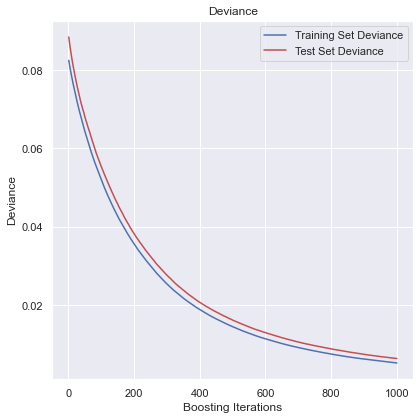

In [22]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

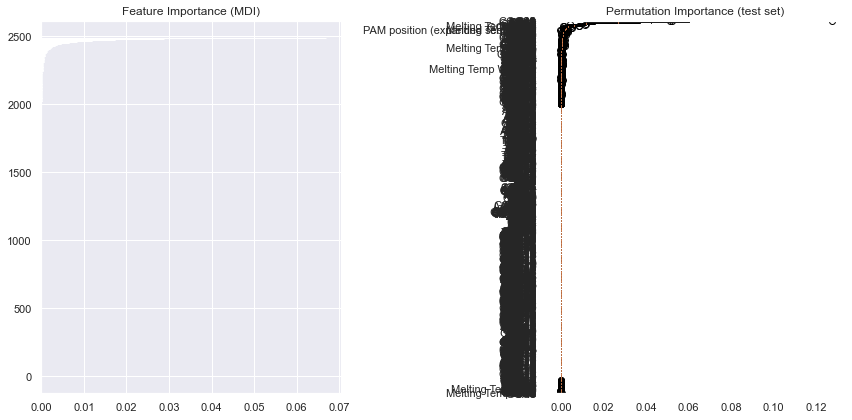

In [23]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
# plt.yticks(pos, x_feat)[sorted_idx]
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=x_feat[sorted_idx], # this might break it
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Linear Regression

In [199]:
ols = LinearRegression()
ols.fit(x, y)
ols_ypred = ols.predict(X_test)
#mse = mean_squared_error(y_test, ols.predict(X_test))
#print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

get_metrics(y_test, ols_ypred)

{'mse': 0.04374375859333745,
 'r2': 0.49089224877288906,
 'spearman': 0.6955635139477749}

In [25]:
lr_cvssc = cross_validate_regression(ols, df, x_feat, y_feat, 10)
lr_cvssc

array([0.7815819 , 0.78872917, 0.79138436, 0.74497001, 0.69796054,
       0.67687351, 0.73209463, 0.7348986 , 0.80272193, 0.82385991])

##### Graphs for LR

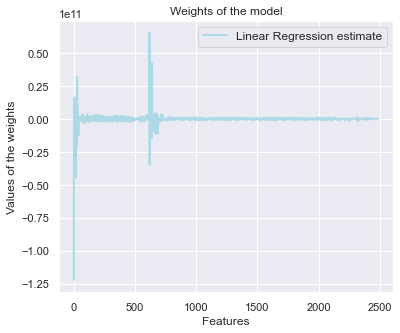

In [87]:
lw = 2
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(ols.coef_, color="lightblue", linewidth=lw, label="Linear Regression estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

In [114]:
# Making a dataframe to sort feature importances
imp_df = pd.DataFrame()
imp_df['Features'] = x_feat
imp_df['Coefs'] = ols.coef_
imp_df = imp_df.sort_values(by=['Coefs'], ascending = False)
imp_df.head(10)

,Features,Coefs
618,GC Count,6.523270e+10
638,AGC1,4.201290e+10
639,AGT1,4.188166e+10
636,AGA1,4.178179e+10
637,AGG1,4.114135e+10
27,G2,3.198103e+10
5,GA1,1.618409e+10
11,CA1,1.078123e+10
29,GG2,1.013525e+10
17,TA1,9.098681e+09


In [115]:
imp_df.tail(10)

,Features,Coefs
2,AT1,-2.156339e+10
10,C1,-2.373818e+10
1,AC1,-2.557540e+10
16,T1,-2.565402e+10
4,G1,-2.700624e+10
620,Melting Temp Wallace,-3.483780e+10
6,GG1,-4.021198e+10
12,CG1,-4.154548e+10
18,TG1,-4.418257e+10
0,AG1,-1.222123e+11


### Bayesian Ridge Regression

In [185]:
# Fit the Bayesian Ridge Regression and an OLS for comparison
clf = BayesianRidge(compute_score=True)
clf.fit(x, y)

clf_ypred = clf.predict(X_test)
get_metrics(y_test, clf_ypred)

{'mse': 0.052128831272366935,
 'r2': 0.39330334391488775,
 'spearman': 0.6290249363555822}

In [28]:
brr_cvssc = cross_validate_regression(clf, df, x_feat, y_feat, 10)
brr_cvssc

array([0.95871864, 0.95313358, 0.94350851, 0.93684192, 0.94077321,
       0.95305347, 0.94645555, 0.9554111 , 0.95607776, 0.94849081])

##### Graphs

In [183]:
'''clf_df = pd.DataFrame()
clf_df['Features'] = x_feat
clf_df['Coefs'] = clf.coef_
clf_df = clf_df.sort_values(by=['Coefs'], ascending = False)
clf_df.head(10)'''

,Features,Coefs
2488,Delta G,0.049819
2487,TTT,0.034090
2486,TTC,0.027226
2485,TTG,0.027172
2484,TTA,0.026938
2483,TCT,0.026908
2482,TCC,0.025587
2481,TCG,0.025367
2480,TCA,0.024380
2479,TGT,0.023537


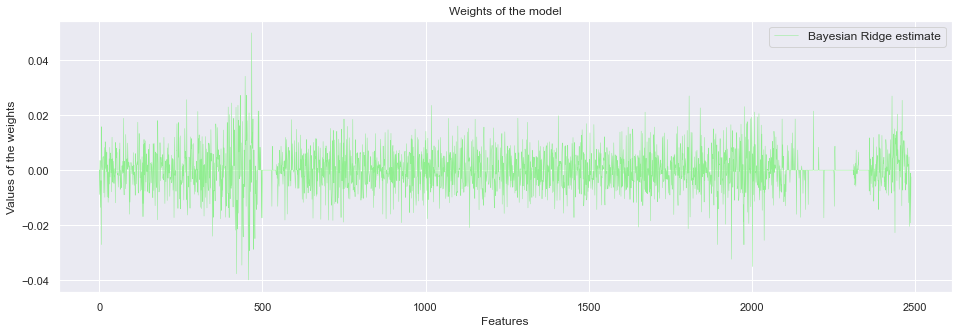

In [190]:
lw = .5
plt.figure(figsize=(16, 5))
plt.title("Weights of the model")
# plt.plot(ols.coef_, color="lightblue", linestyle="--", label="Linear Regression estimate")
plt.plot(clf.coef_, color="lightgreen", linewidth=lw, label="Bayesian Ridge estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

## Neural Network Regressor

In [192]:
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        # Params from grid search
        hidden_layer_sizes=(100, 100),
        learning_rate_init=0.0005,
        early_stopping=True,
        random_state=0,
        activation='tanh',
    ),
)
est.fit(X_train, y_train)
est_ypred = est.predict(X_test)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 18.025s
Test R2 score: 0.26


In [195]:
get_metrics(y_test, est_ypred)

{'mse': 0.06342009500244601,
 'r2': 0.2618909991373556,
 'spearman': 0.4995779156954908}

In [31]:
nn_cvssc = cross_validate_regression(est, df, x_feat, y_feat, 10)
nn_cvssc

## Lasso Regressor

In [211]:
from sklearn.linear_model import Lasso

In [233]:
las = Lasso(alpha = .001, max_iter = 1000000, random_state = 42)
las.fit(x, y)
las_ypred = las.predict(X_test)

get_metrics(y_test, las_ypred)

{'mse': 0.060835988992571276,
 'r2': 0.2919658816331675,
 'spearman': 0.5321053944157195}

In [ ]:
las_cvssc = cross_validate_regression(las, df, x_feat, y_feat, 10)
las_cvssc

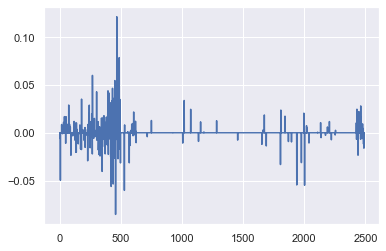

In [234]:
# Exploring features reduced to 0
plt.plot(las.coef_)

In [251]:

from sklearn.linear_model import Lasso
las = Lasso(alpha = .001, max_iter = 1000000, random_state = 42)
las.fit(x, y)
las_ypred = las.predict(X_test)


lasso_df = pd.DataFrame()

lasso_df['Features'] = x_feat
lasso_df['Coefs'] = las.coef_

# .001 gets 216 features, .01 gets 108, .025 gets 40
threshold = .025
important_feats = lasso_df[abs(lasso_df['Coefs']) > threshold]
important_feats

,Features,Coefs
6,GG1,-0.049659
74,CG4,0.029053
179,TG9,0.035246
229,GG12,-0.029335
242,A13,0.028933
268,GA14,0.060088
302,A16,0.042917
347,G18,-0.040427
395,CC20,0.043928
405,AC21,0.041504


In [252]:
x_feat[-5:]

array(['TTA', 'TTG', 'TTC', 'TTT', 'Delta G'], dtype=object)

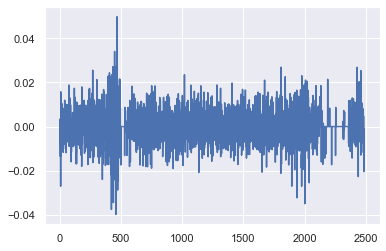

In [239]:
plt.plot(clf.coef_)

## Model Performance

<BarContainer object of 4 artists>

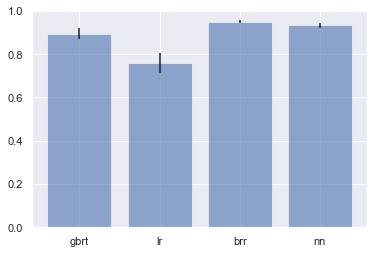

In [32]:
models = ['gbrt', 'lr', 'brr', 'nn']
values = [gbrt_cvssc.mean(), lr_cvssc.mean(), brr_cvssc.mean(), nn_cvssc.mean()]
# error = [sem(gbrt_cvssc), sem(lr_cvssc), sem(brr_cvssc), sem(nn_cvssc)]
error = [gbrt_cvssc.std(), lr_cvssc.std(), brr_cvssc.std(), nn_cvssc.std()]

plt.bar(models, values, yerr=error, alpha=0.6)

In [200]:


print(get_metrics(y_test, reg_ypred))
print(get_metrics(y_test, ols_ypred))
print(get_metrics(y_test, clf_ypred))
print(get_metrics(y_test, est_ypred))

{'mse': 0.04721720601298133, 'r2': 0.45046684725995545, 'spearman': 0.7287846987853965}
{'mse': 0.04374375859333745, 'r2': 0.49089224877288906, 'spearman': 0.6955635139477749}
{'mse': 0.052128831272366935, 'r2': 0.39330334391488775, 'spearman': 0.6290249363555822}
{'mse': 0.06342009500244601, 'r2': 0.2618909991373556, 'spearman': 0.4995779156954908}


In [209]:
model_names = ['GB Reg Tree', 'Linear Reg', 'Bayesian Ridge Reg', 'Neural Network Reg']
metric_names = ['mse', 'r2', 'spearman']

metrics_dict = {
    "reg" : get_metrics(y_test, reg_ypred),
    "ols" : get_metrics(y_test, ols_ypred),
    "clf" : get_metrics(y_test, clf_ypred),
    "est" : get_metrics(y_test, est_ypred)
    #, "las" : get_metrics(y_test, las_ypred)
}

metrics_df = pd.DataFrame(index = model_names, columns = metric_names)

for metric in metric_names:
    metric_list = []
    for model in metrics_dict:
        value = metrics_dict[model][metric]
        metric_list.append(value)
    metrics_df[metric] = metric_list

metrics_df['Model'] = metrics_df.index
metrics_df

,mse,r2,spearman,Model
GB Reg Tree,0.047217,0.450467,0.728785,GB Reg Tree
Linear Reg,0.043744,0.490892,0.695564,Linear Reg
Bayesian Ridge Reg,0.052129,0.393303,0.629025,Bayesian Ridge Reg
Neural Network Reg,0.063420,0.261891,0.499578,Neural Network Reg


<AxesSubplot:title={'center':'Grouped Bar Graph with dataframe'}, xlabel='Model'>

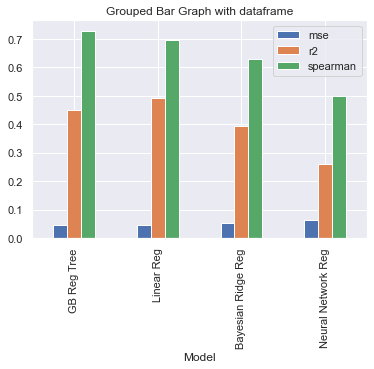

In [210]:
metrics_df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe')